In [1]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import plotly.graph_objects as go
import polars
import theme

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [2]:
def load_data(directory):
    run_data = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results.csv')
    )
    memory_log = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results-memory.csv')
    )
    return run_data, memory_log

In [3]:
def extract_memory_logs(run_data, memory_log):
    memory_logs = {}

    data_management_methods = (
        run_data.select(polars.col('data_management')).to_series().to_list()
    )

    for data_management in data_management_methods:
        runs = run_data.filter(
            polars.col('data_management') == data_management,
        )

        run_memory_logs = []
        for i, run in enumerate(runs.iter_rows(named=True)):
            run_start = run['workflow_start_timestamp']
            run_end = run['workflow_end_timestamp']

            run_memory_log = memory_log.filter(
                run_start <= polars.col('unix_timestamp'),
            ).filter(polars.col('unix_timestamp') <= run_end)
            run_memory_log = (
                run_memory_log.select(
                    # Round to 10 ms here
                    (polars.col('unix_timestamp') - run_start)
                    .round(2)
                    .alias('timestamp'),
                    (
                        (
                            polars.col('total_bytes')
                            - polars.col('available_bytes')
                        )
                        / int(1e9)
                    ).alias('used_gb'),
                )
                .group_by('timestamp', maintain_order=True)
                .mean()
                .sort('timestamp')
            )
            run_memory_log = run_memory_log.select(
                polars.col('timestamp'),
                polars.col('used_gb').alias(f'run-{i}-used_gb'),
            )
            run_memory_logs.append(run_memory_log)

        for i in range(1, len(run_memory_logs)):
            run_memory_logs[0] = (
                run_memory_logs[0]
                .join(
                    run_memory_logs[i],
                    on='timestamp',
                    how='outer_coalesce',
                )
                .sort('timestamp')
                .select(polars.all().forward_fill())
            )

        memory_logs[data_management] = run_memory_logs[0].select(
            polars.col('timestamp'),
            polars.concat_list(polars.col('^run-\d+-used_gb$'))
            .list.mean()
            .alias('mean_used_gb'),
            polars.concat_list(polars.col('^run-\d+-used_gb$'))
            .list.std()
            .alias('std_used_gb'),
        )

    return memory_logs

In [12]:
def generate_figure(memory_logs, layout=None):
    fig = go.Figure()
    
    names = {
        'none': 'No Proxy',
        'default-proxy': 'Default',
        'manual-proxy': 'Manual',
        'owned-proxy': 'Ownership',
    }

    max_x = 0
    
    colors = px.colors.qualitative.Bold[0:4][::-1]
    for i, data_management in enumerate(names.keys()):
        if data_management not in memory_logs:
            continue
        memory_profile = memory_logs[data_management]
        color = colors[i]
        fill_color = color.replace(')', ', 0.25)').replace('rgb', 'rgba')
        scatter_line = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'],
            name=names[data_management],
            line=dict(color=colors[i]),
            mode='lines',
        )
        scatter_upper = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'] + memory_profile['std_used_gb'],
            name=f'{data_management}-stdev-upper',
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False,
        )
        scatter_lower = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'] - memory_profile['std_used_gb'],
            name=f'{data_management}-stdev-lower',
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor=fill_color,
            fill='tonexty',
            showlegend=False,
        )

        if data_management == 'default-proxy':
            max_x = 1.1 * max(memory_profile['timestamp'])

        fig.add_trace(scatter_line)
        fig.add_trace(scatter_upper)
        fig.add_trace(scatter_lower)

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Memory Management'},
        xaxis_title='Time (s)',
        yaxis_title='System Memory Usage (GB)',
        yaxis={'tickformat': '.2f'},
        xaxis_range=[0, max_x],
        legend=dict(yanchor='top', y=0.98, xanchor='left', x=0.01, title='Proxy Management', traceorder='reversed'),
        template='proxystore',
        **layout,
    )

    return fig

## Alderaan Testing Run

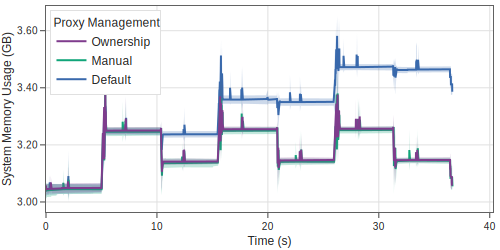

In [5]:
run_data, memory_log = load_data('../data/alderaan/2-memory-management')

memory_logs = extract_memory_logs(run_data, memory_log)

layout = dict(width=500, height=250)

fig = generate_figure(memory_logs, layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/alderaan/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '2-memory-management.pdf')

## Polaris

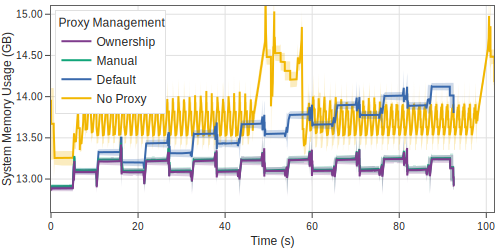

In [16]:
run_data, memory_log = load_data('../data/polaris/2-memory-management')
memory_logs = extract_memory_logs(run_data, memory_log)

layout = dict(width=500, height=250, yaxis_range=[12.6, 15.1])

fig = generate_figure(memory_logs, layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '2-memory-management.pdf')